# Creating Custom Captum.optim Modules
Captum's Optim library contains an extensive list of optimization objectives, transforms, and input parameterizations. However, some cases may require adding new features to these areas of Captum's Optim library. Luckily adding them to Captum is easy!

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Dict, List, Optional, Tuple, Union

import torch
import torchvision
from captum.optim._models.inception_v1 import googlenet

import captum.optim as opt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device)

# Custom Image Transforms

If both Captum and Torchvision lack the transforms that you require, then you can create your own custom transforms.

Custom image transform classes must contain a `forward()` function. The first transform in a list of transforms takes an input tensor with a shape of (B, C, W, H), and the final transform in a list of transforms will need to output a tensor with the same shape of (B, C, W, H). Captum and Torchvision's transforms normally expect and output a shape of (B, C, W, H).

An optional `__init__()` function can be used as well.


Note that all custom transforms need to be autograd compatible, so that the gradient is not interrupted during the optimization process.


In [2]:
class CustomTransform(torch.nn.Module):
    def __init__(self, val: int = 1) -> None:
        super(CustomTransform, self).__init__()
        self.val = val

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return input * self.val

# Custom Loss Functions
Captum's loss functions are composed of classes that the optimization function uses. Custom loss classes should inherit the base loss class.

Custom loss functions must contain the following two functions:


* The `__init__()` function with that must at least contain a target variable. The target variable should be an nn.module or list of nn.modules to collect activations from. Other variables can be added after the target.

* The `__call__()` function which takes activations from the target layer and then returns a loss value. Activations sent to the call function are extracted from a dictionary with the target as the key.

In [3]:
class CustomLoss(opt.loss.SimpleLoss):
    def __init__(self, target: Union[torch.nn.Module, List[torch.nn.Module]]):
        super(CustomLoss, self).__init__()
        self._target = target

    def __call__(
        self, target_activations: Dict[torch.nn.Module, Optional[torch.Tensor]]
    ) -> torch.Tensor:
        activations = target_activations[self.target]  # Get activations from target
        return activations

# Custom Image Parameterization


The image parameters that Captum's Optim library optimizes to produce visualizations is stored in a custom image parameterization class. 

Custom parameterization must contain the following two functions:

### Init function

The `__init__()` function has 3 input variables:

* size (tuple, int): dimensions in the form height, width. 

* channels (int): the number of channels for the output tensor.

* batch (int): the desired batch size to use.

* init (torch.Tensor): An optional input tensor with a shape of: (B, C, W, H).

Make sure that the tensor being optimized is wrapped in `torch.nn.Parameter` and that it can be called by the `forward()` function.

### Forward function

The `forward()` function has zero input varibles and returns a 4 dimension tensor with a shape of (B, C, W, H):

* The tensor being optimized should be called from where it was saved in the init function. This tensor will then be returned when the forward function is called.

* The dimensions of the output tensor should be named: 'B', 'C', 'H', and 'W'.

In [4]:
class CustomImage(opt.images.ImageParameterization):
    def __init__(
        self,
        size: Tuple[int, int] = (224, 224),
        channels: int = 3,
        batch: int = 1,
        init: torch.Tensor = None,
    ) -> None:
        super().__init__()
        if init is None:
            assert size is not None
            # Create random input with a shape of: B, C, W, H
            init = torch.randn([batch, channels, size[0], size[1]])
        else:
            assert init.dim() == 4
        self.image = torch.nn.Parameter(init)  # Convert input to nn.Parameter()

    def forward(self) -> torch.Tensor:
        return self.image.refine_names("B", "C", "H", "W")  # rename dimensions

# Running Captum with custom modules

Below is a helper function that will let us quickly and easily experiment with our custom modules from above. Random scaling and random spatial jitter transforms are also included in the helper function to improve output quality.

In [5]:
def visualize(model, target):
    # Define our custom image parameterization, then add it to NaturalImage
    image_param = CustomImage
    image = opt.images.NaturalImage(size=(224, 224), parameterization=image_param)

    transforms = torch.nn.Sequential(
        CustomTransform(),  # Add our custom transform to the list of transforms

        # Additional transforms to improve output quality
        opt.transform.RandomSpatialJitter(16),
        opt.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    )

    # Define our custom loss function as the loss function
    loss_fn = CustomLoss(target)

    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(opt.optimization.n_steps(128))
    image().show()

/usr/local/lib/python3.8/site-packages/torch/tensor.py:775: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:848.)
  return super(Tensor, self).refine_names(names)


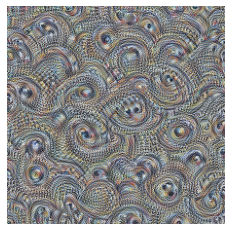

In [6]:
visualize(model, model.mixed4a)